In [57]:
import pandas as pd
import nltk
import json  
import sys  
import numpy as np

import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.manifold import TSNE  
from sklearn.decomposition import PCA  
import random  

from transformers import AutoImageProcessor, ResNetForImageClassification  
import torch  
from PIL import Image  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  


In [100]:
df = pd.read_csv("./../input/df_cleaned_v2.csv")

In [16]:
def modify_labels(y_true, y_pred):  
    """  
    Modifies the predicted values based on the confusion matrix.  
    """  
    cm = confusion_matrix(y_true, y_pred)  
    n_classes = len(np.unique(y_true))  
    modified_pred = np.copy(y_pred)
    
    mapping = {}
    for true_label in range(n_classes): 
        max_count = -1  
        for pred_label in range(n_classes):
            if cm[true_label, pred_label] > max_count and pred_label not in mapping.values():  
                max_count = cm[true_label, pred_label]
                mapping[true_label] = pred_label
        
        # print(mapping)
        # # print(mapping)
        # print(f"Replace y_pred {mapping[true_label]} by {true_label}, because {max_count}")
        # print()
    for true_label, pred_label in mapping.items():  
         modified_pred[y_pred == pred_label] = true_label
        
    return modified_pred

# Texte

## Image

https://paperswithcode.com/task/image-classification

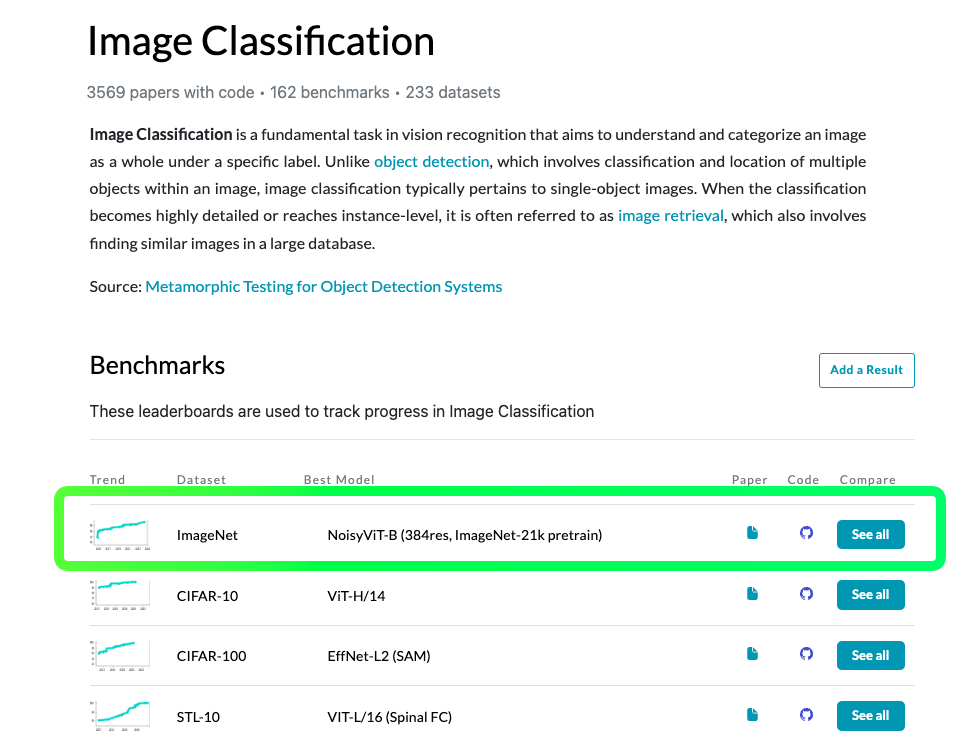

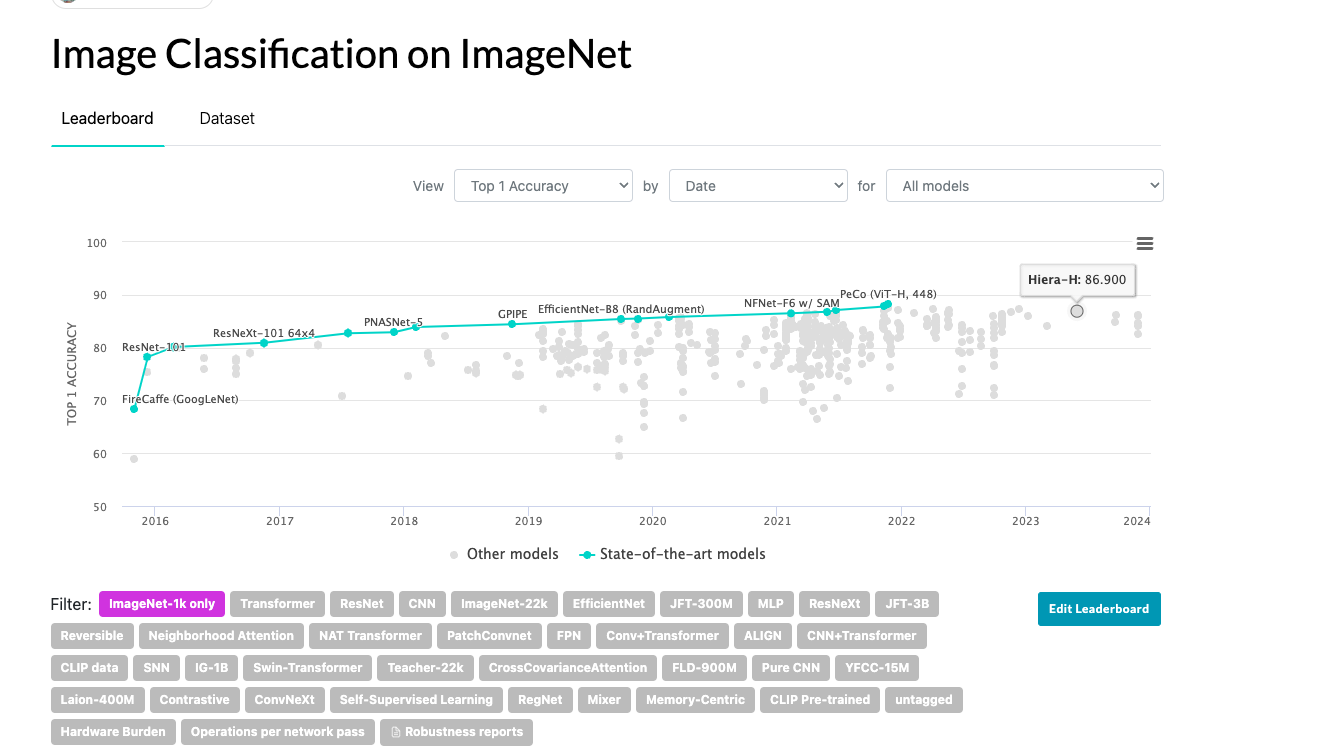

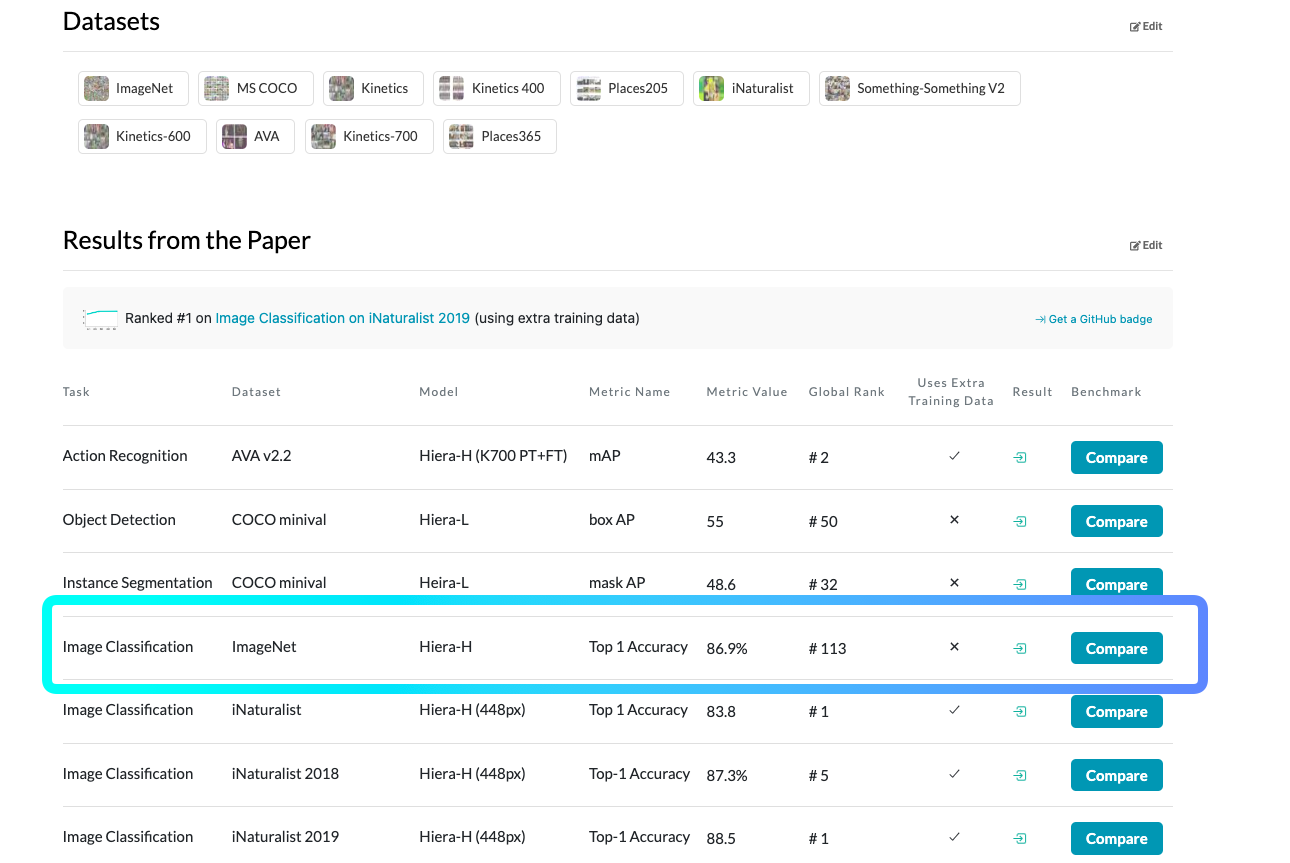

Approche différente (Mon feature image se base sur le predict du model plutot que de faire un .fit)

In [83]:
import torch  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score  
import pandas as pd  
from PIL import Image  
from torchvision import transforms  
from tqdm import tqdm  

In [67]:
# Smaller model implementation
model = torch.hub.load("facebookresearch/hiera", model="hiera_base_224", pretrained=True, checkpoint="mae_in1k_ft_in1k")  

Downloading: "https://github.com/facebookresearch/hiera/zipball/main" to /Users/m/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/hiera/hiera_base_224.pth" to /Users/m/.cache/torch/hub/checkpoints/hiera_base_224.pth
100%|██████████| 590M/590M [00:24<00:00, 25.6MB/s] 


In [68]:
model.eval()

Hiera(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (unroll): Unroll()
  (reroll): Reroll()
  (blocks): ModuleList(
    (0-1): 2 x HieraBlock(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): MaskUnitAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (proj): Linear(in_features=96, out_features=96, bias=True)
      )
      (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=384, out_features=96, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
    )
    (2): HieraBlock(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): MaskUnitAttention(


In [107]:
# Define the image transformations that were used when the model was trained  
preprocess = transforms.Compose([  
    transforms.Resize(256),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(),  
])  

In [108]:
# Feature extraction function  
def extract_features(img_path, model, preprocess):  
    input_image = Image.open(img_path).convert('RGB')  
    input_tensor = preprocess(input_image)  
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension  
  
    with torch.no_grad():  
        features = model(input_batch)  
      
    return features[0]  
  

In [109]:
# Extract features for each image  
features = []
for img_path in tqdm(df['img_path'], desc="Extracting features"):  
    features.append(extract_features(img_path, model, preprocess).numpy())  


Extracting features:  64%|██████▍   | 677/1050 [00:56<00:31, 11.98it/s]/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Extracting features: 100%|██████████| 1050/1050 [01:30<00:00, 11.58it/s]


In [110]:
labels = df['cat_e'].values  
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)  

In [111]:
# Initialize and train the RandomForest classifier  
clf = RandomForestClassifier(n_estimators=100, random_state=42)  
clf.fit(X_train, y_train)  

# Predict on the test set  
y_pred = clf.predict(X_test)  

# Calculate accuracy  
accuracy = accuracy_score(y_test, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.95%


In [112]:
transform = transforms.Compose([  
    # Add necessary preprocessing steps here (e.g., resizing, normalization):  
    # transforms.Resize((224, 224)),  
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])  
])  